# Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте
результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

    • EventName — название события;
    • DeviceIDHash — уникальный идентификатор пользователя;
    • EventTimestamp — время события;
    • ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b> 
    
Здорово, что выделено содержание, описана цель и данные. 👍
    
Еще можно добавить заголовок, который будет отражать основную суть проекта проекта и table of contents (ToC) для удобства перемещения по проекту.
</div>


## Шаг. Откройте файл с данными и изучите общую информацию

In [ ]:
#импортируем библиотеки 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth


In [ ]:
##откроем таблицу
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


При первом знакомстве с таблицей видим, что необходимо название колонок привести к другому виду. Имеем колонки с индексом, с разными названиями событий, уникальные идентификаторы пользователя, время события, которое в секундах, и номерами групп. 

## Шаг. Подготовьте данные

In [ ]:
#переименуем столбцы
data.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'device_id_hash',\
                      'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'}, inplace = True )
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [ ]:
#изучим информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
#cоздадим столбцы
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Создали столбцы с датой и временем, приведя к нужному формату. Остальные столбцы  имеют правильные типы данных и  корректировка не нужна. Имеем 244126 строк в таблице.

In [ ]:
#найдем количество пользователей, которые присутствуют и группе 246 и в группе 247
print('Количество пользователей, которые присутствуют и группе 246 и в группе 247: {}'.\
      format(len(np.intersect1d(data.query('exp_id==246')['device_id_hash'].unique(),\
                   data.query('exp_id==247')['device_id_hash'].unique()))))

Количество пользователей, которые присутствуют и группе 246 и в группе 247: 0


In [ ]:
#найдем количество пользователей, которые присутствуют и группе 246 и в группе 248
print('Количество пользователей, которые присутствуют и группе 246 и в группе 248: {}'.\
      format(len(np.intersect1d(data.query('exp_id==246')['device_id_hash'].unique(),\
                   data.query('exp_id==248')['device_id_hash'].unique()))))

Количество пользователей, которые присутствуют и группе 246 и в группе 248: 0


In [ ]:
#найдем количество пользователей, которые присутствуют и группе 247 и в группе 248
print('Количество пользователей, которые присутствуют и группе 247 и в группе 248: {}'.\
      format(len(np.intersect1d(data.query('exp_id==247')['device_id_hash'].unique(),\
                   data.query('exp_id==248')['device_id_hash'].unique()))))

Количество пользователей, которые присутствуют и группе 247 и в группе 248: 0


Пересечения пользователей в группах нет.


## Шаг. Изучите и проверьте данные

In [ ]:
#изучим пропуски в значениях 
data.isna().mean()

event_name         0.0
device_id_hash     0.0
event_timestamp    0.0
exp_id             0.0
date_time          0.0
date               0.0
dtype: float64

*Пропуски в таблице отсутствуют.*

In [ ]:
#проверим на наличие дубликатов в таблице
data.duplicated().sum()

413

In [ ]:
#удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

*Обнаружили 413 дубликатов в таблице, удалим их, чтобы они не влияли на результаты.*

In [ ]:
#выведем сколько всего событий в логе
events = len(data)

print('Всего событий в логе: {}'.format(events))

Всего событий в логе: 243713


In [ ]:
#выведем уникальные значения столбца
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [ ]:
#выведем число уникальных пользователей
users = data['device_id_hash'].nunique()
print('Число уникальных пользователей: {}'.format(users))

Число уникальных пользователей: 7551


*Выяснили, что*
*Всего событий в логе: 243713,*

*Имеем 5 названий событий,*

*Всего число уникальных пользователей: 7551*

In [ ]:
#выведем среднее значение событий на пользователя
print('Количество событий на одного пользователя: медианное - {}, мода - {}'.format(
                                                            data['device_id_hash'].value_counts().median(),
                                                            data['device_id_hash'].value_counts().mode()[0]))

Количество событий на одного пользователя: медианное - 20.0, мода - 5


Медианное количество событий на одного пользователя равно 20, и часто встречающееся число событий -5.

In [ ]:
#посмотрим основные показатели числа событий на пользователя
data['device_id_hash'].value_counts().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: device_id_hash, dtype: float64

 Максимальное число событий у одного пользователя составляет 2308, среднее - 32, медианная -20, даже 75% - это 37 событий. Т.е. есть большие перепады в значениях, выбросы.
 

In [ ]:
#Выведем минимальное и максимальное значение даты
print('Временные рамки: начало - {}, конец - {}'.\
      format(data['date_time'].min(), data['date_time'].max()))

Временные рамки: начало - 2019-07-25 04:43:36, конец - 2019-08-07 21:15:17


*Определили временные рамки: начало - 2019-07-25 04:43:36, конец - 2019-08-07 21:15:17, т.е  2 недели.*

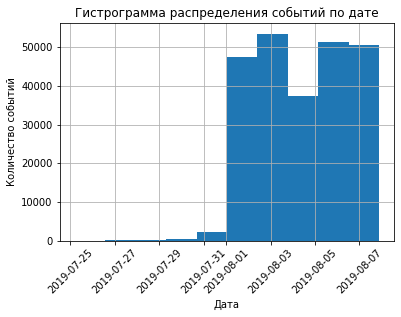

In [ ]:
#Построим гистограмму событий по дате
plt.hist(data['date_time'])

plt.title('Гистрограмма распределения событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

*По **Гистрограмме распределения событий по дате** видно, что полные данные у нас есть только за период с 1 по 7 августа включительно. Поэтому будем использовать этот период для дальнейшего исследования.*

In [ ]:
#Урежим таблицу по выбранной дате
data_filterad = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
data = data[data['date'] >= data_filterad]

#зададим переменные с числом строк и уникальных пользовотаелей по новой таблице
events_filtered = len(data)
users_filtered = data['device_id_hash'].nunique()

data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [ ]:
#Выведем количество событий до фильтрации, после и разность
print('Количество событий до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        events, events_filtered,
                                                                        events - events_filtered,
                                                                        round(100-events_filtered/events*100, 2)))
#Выведем количество пользователей до фильтрации, после и разность
print('Количество пользователей до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        users, users_filtered,
                                                                        users - users_filtered,
                                                                        round(100-users_filtered/users*100, 2)))

Количество событий до фильтрации - 243713, после - 240887. Разность - 2826 или 1.16%
Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17 или 0.23%


*Проверили количество событий до фильтрации - 243713, после - 240887. Разность - 2826 или 1.16%.*

*Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17 или 0.23%.*

*Доля удаленных данных небольшая, поэтому не повлияет на дальнейшее исследование.*

In [ ]:
#выведем число пользователей в группах
data.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

*Видим, что в группе 246 - 2484 уникальных пользователя, в 247 группе - 2513 человек, в 248 группе - 2537 пользователя. Т.е. имеется между ними небольшая разница.*

## Шаг. Изучите воронку событий

In [ ]:
#выведем число пользователей по событиям в таблицу
events_count = data['event_name'].value_counts().to_frame()
events_count

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [ ]:
#создадим функцию подсчета уникальных пользователей на каждое событие
def get_event_count(event):
    users_count = data[data['event_name'] == event]['device_id_hash'].nunique()
    return users_count

In [ ]:
#добавим столбец уникальных пользователей на каждое событие
events_count = events_count.reset_index()
events_count['unique_users'] = events_count['index'].apply(get_event_count)
events_count = events_count.sort_values(by='unique_users', ascending=False)
events_count = events_count.set_index('index')
events_count.index.name = None

In [ ]:
#создадим столбец доли уникальных пользователей на каждое событие
events_count['percent'] = events_count['unique_users'].apply(lambda x: round(x/7419*100, 2))
     
events_count.head()

,event_name,unique_users,percent
MainScreenAppear,117328,7419,100.00
OffersScreenAppear,46333,4593,61.91
CartScreenAppear,42303,3734,50.33
PaymentScreenSuccessful,33918,3539,47.70
Tutorial,1005,840,11.32


In [ ]:
#создадим столбец с долей пользователей, которые перешли от одного этапа на другой
events_count = events_count.reset_index(drop=False)
for i in events_count.index:
    if i ==0:
        events_count.loc[i, 'percent_user_total'] = 100
    else:
        events_count.loc[i, 'percent_user_total'] = (events_count.loc[i,'unique_users']/
                                                   events_count.loc[i-1,'unique_users']*100
                                                  )
events_count

,index,event_name,unique_users,percent,percent_user_total
0,MainScreenAppear,117328,7419,100.00,100.000000
1,OffersScreenAppear,46333,4593,61.91,61.908613
2,CartScreenAppear,42303,3734,50.33,81.297627
3,PaymentScreenSuccessful,33918,3539,47.70,94.777718
4,Tutorial,1005,840,11.32,23.735519



События происходят в следующем порядке:

    MainScreenAppear - появление главного экрана;
    Tutorial - прохождение обучения по использоваю приложения (по желанию);
    OffersScreenAppear - предложение о товаре (экран с товаром);
    CartScreenAppear - переход в корзину;
    PaymentScreenSuccessful - экран успешной оплаты заказа.

Этап Tutorial тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. При изучении числа пользователей по событиям, видим, что больше всего человек в **MainScreenAppear -появление главного экрана** -117328, а самое маленькой число участников в событии **Tutorial- прохождение обучения по использоваю приложения (по желанию)** - 1005. Т.е. и событий этого типа слишком мало для анализа по сравнению с другими. Всего 11,32% из всех пользователей доходит от первого события и  до события **Tutorial**.

50% из всего числа уникальных пользователей дошли до перехода в корзину. 47,70% людей оплатли свои покупки.

Всего уникальных пользователей, которые учавствовали в первом событии - 7419 человека, А всего- 7534, т.е. 115 человек начали свою работу не с **MainScreenAppear - появление главного экрана** на мобильном приложении.


 Доля пользователей, которые перешли из 1 этапа в OffersScreenAppear:2 этап - 61.9%. Доля пользователей, которые закончили выбирать товар на этапе 2 и  перешли в корзину составлет 81,3%, Те, кто прошел от корзины до оплаты 94,7%, до  обучающего ролика дошли лишь 23,7%.
    


In [ ]:
#создадим таблицу без события Tutorial
data_funnel = data[data['event_name'] != 'Tutorial']

In [ ]:
#посчитаем количество пользователей поэтапно
users = data.pivot_table(index='device_id_hash', 
                         columns='event_name', 
                         values='date',
                         aggfunc='min')

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen = users[step_1].shape[0]
print('Количество пользователей, которые учавствовали в событии MainScreenAppear:1 этап - {}'.format(n_main_screen))
n_offer = users[step_2].shape[0]
print('Количество пользователей, которые учавствовали в событии OffersScreenAppear:2 этап - {}'.format(n_offer))
n_cart = users[step_3].shape[0]
print('Количество пользователей, которые учавствовали в событии CartScreenAppear:3 этап - {}'.format(n_cart))      
n_payment_successful = users[step_4].shape[0]
print('Количество пользователей, которые учавствовали в событии PaymentScreenSuccessful:4 этап - {}'\
      .format(n_payment_successful))

Количество пользователей, которые учавствовали в событии MainScreenAppear:1 этап - 7419
Количество пользователей, которые учавствовали в событии OffersScreenAppear:2 этап - 688
Количество пользователей, которые учавствовали в событии CartScreenAppear:3 этап - 33
Количество пользователей, которые учавствовали в событии PaymentScreenSuccessful:4 этап - 1


*Количество пользователей, которые начали с события **появление главного экрана**:1 этап - 7419 человек, 
на 2 этапе **предложение о товаре (экран с товаром)** перешло - 688 человек,
**перешли  в корзину**- 3 этап - 33 человека, а **оплатил свои покупки** всего 1 человек.*

*Изучим число пользователей в долях по событиям.*

In [ ]:
#Выведем доли пользователей по событиям
print('Доля пользователей, которые учавствовали в событии MainScreenAppear:1 этап - {}%'.format(
    round(n_main_screen/n_main_screen*100, 2)))
print('Доля пользователей, которые учавствовали в событии OffersScreenAppear:2 этап - {}%'.format(
    round(n_offer/n_main_screen*100, 2)))
print('Доля пользователей, которые учавствовали в событии CartScreenAppear:3 этап - {}%'.format(
    round(n_cart/n_main_screen*100, 2)))
print('Доля пользователей, которые учавствовали в событии PaymentScreenSuccessful:4 этап - {}%'.format(
    round(n_payment_successful/n_main_screen*100, 2)))

Доля пользователей, которые учавствовали в событии MainScreenAppear:1 этап - 100.0%
Доля пользователей, которые учавствовали в событии OffersScreenAppear:2 этап - 9.27%
Доля пользователей, которые учавствовали в событии CartScreenAppear:3 этап - 0.44%
Доля пользователей, которые учавствовали в событии PaymentScreenSuccessful:4 этап - 0.01%


*Если взять за 100% событие **появление главного экрана**:1 этап, то всего 9,27% перешли к следующему этапу **по предложению о товаре (экран с товаром)** и лишь 0,44% **перешли  в корзину**- 3 этап. А до последнего 4 этапа дошло лишь 0,01%.* 

*Т.е. большой отсев произошел уже при переходе к товарам и так же могли быть какие то вопросы и трудности при оплате.*

In [ ]:
#Выведем доли пользователей по событиям
print('Доля пользователей, которые учавствовали в событии MainScreenAppear:1 этап - {}%'.format(
    round(n_main_screen/n_main_screen*100, 2)))
print('Доля пользователей, которые перешли из 1 этапа в OffersScreenAppear:2 этап - {}%'.format(
    round(n_offer/n_main_screen*100, 2)))
print('Доля пользователей, которые перешли из 2 этапа в CartScreenAppear:3 этап - {}%'.format(
    round(n_cart/n_offer*100, 2)))
print('Доля пользователей, которые перешли из 3 этапа в PaymentScreenSuccessful:4 этап - {}%'.format(
    round(n_payment_successful/n_cart*100, 2)))

Доля пользователей, которые учавствовали в событии MainScreenAppear:1 этап - 100.0%
Доля пользователей, которые перешли из 1 этапа в OffersScreenAppear:2 этап - 9.27%
Доля пользователей, которые перешли из 2 этапа в CartScreenAppear:3 этап - 4.8%
Доля пользователей, которые перешли из 3 этапа в PaymentScreenSuccessful:4 этап - 3.03%


Доля пользователей, которые перешли из 1 этапа в OffersScreenAppear:2 этап - 9.27%. Доля пользователей, которые закончили выбирать товар на этапе 2 и  перешли в корзину составлет 4,8%, Те, кто прошел от корзины до оплаты 3,03%
    


## Шаг. Изучите результаты эксперимента

In [ ]:
#выведем число пользователей в группах
data.groupby('exp_id')['device_id_hash'].nunique().to_frame()

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


In [ ]:
#Выведем информацию по событиям по каждой группе
users_by_events = data.pivot_table(index = 'exp_id',
                                   columns = 'event_name',
                                   values = 'device_id_hash',
                                   aggfunc = 'nunique').reset_index()
users_by_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


*Отметим, что во всех группах числа уникальных пользовотелей по разным событиям распределены приблизительно одинаково.*

In [ ]:
#напишем функцию получения p_value с заданием alpha- критический уровень статистической значимости
def st_test(successes0, successes1, trials0, trials1, alpha):  
    
# пропорция успехов в первой группе:
    p1 = successes0 / trials0 
# пропорция успехов во второй группе:
    p2 = successes1 / trials1 
# пропорция успехов в комбинированном датасете:
    p_combined = (successes0 + successes1) / (trials0 + trials1) 
# разница пропорций в датасетах
    difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials0 + 1/trials1))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

*Проведем сравнение двух А-групп и убедимся, что тест был проведен корректно и между ними нет статзначимых различий:*

In [ ]:
#добавим столбец с числом пользователей в таблицу
users_count = data.groupby('exp_id')['device_id_hash'].nunique()
users_by_events['users_count'] = users_by_events['exp_id'].apply(lambda x: users_count.loc[x])
users_by_events = users_by_events.set_index('exp_id')
users_by_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
exp_id,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


In [ ]:
#Зададим последовательность столбцов по воронке.
users_by_events = users_by_events[['MainScreenAppear', 'OffersScreenAppear',
                                   'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial', 'users_count']]
users_by_events = users_by_events.reindex([246, 247, 248])
users_by_events   

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
exp_id,,,,,,
246,2450,1542,1266,1200,278,2484
247,2476,1520,1238,1158,283,2513
248,2493,1531,1230,1181,279,2537



 Сформулируем **Нулевую гипотезу** - Разница между долями учавствующих в событии пользователей в группах статистически незначима.
    
  **Альтернативная гипотеза** - Разница между долями учавствующих в событии пользователей в группах статистически значима.
  Проверим это.


In [ ]:
#создадим таблицу для вывода результатов по определению разницы между группами 246,247
AA_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

group_1 = 246
current_row = users_by_events.loc[group_1]
group_2 = 247

#

for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_count'],
                                   users_by_events['users_count'][group_2],
                                   alpha = .05
                           )
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': 0.05,
               'p_value': round(p_value_result, 5),
               'Результат': result_options[p_value_result >= 0.05]}
    AA_pivot = AA_pivot.append([new_row])
    
pd.options.display.max_colwidth = 150
AA_pivot.index = range(len(AA_pivot))
AA_pivot

/tmp/ipykernel_79/1540392551.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'Результат': result_options[p_value_result >= 0.05]}


,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,247,MainScreenAppear,0.05,0.75706,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,246,247,OffersScreenAppear,0.05,0.24810,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,246,247,CartScreenAppear,0.05,0.22883,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,246,247,PaymentScreenSuccessful,0.05,0.11457,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"


*Тест проведен корректно - статзначимых различий между двумя А-группами (246 и 247) не обнаружено.*

In [ ]:
users_by_events 

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
exp_id,,,,,,
246,2450,1542,1266,1200,278,2484
247,2476,1520,1238,1158,283,2513
248,2493,1531,1230,1181,279,2537


In [ ]:
#Посчитайте долю пользователей популярного события MainScreenAppear
round((users_by_events['MainScreenAppear']/users_by_events['users_count'])*100,2)

exp_id
246    98.63
247    98.53
248    98.27
dtype: float64

 По таблице **users_by_events** мы увидели, что больше всего пользователей в событии показа главного экрана во всех трех группах, их процент от общего числа пользователей у всех групп составляет 98%.


In [ ]:
#объединим группы 246 и 247 в новую колонку
new_row = users_by_events.loc[246] + users_by_events.loc[247]
new_row.name = '246_247'
users_by_events = users_by_events.append([new_row])
users_by_events = users_by_events.reindex([246, 247, '246_247', 248])
users_by_events

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
246,2450,1542,1266,1200,278,2484
247,2476,1520,1238,1158,283,2513
246_247,4926,3062,2504,2358,561,4997
248,2493,1531,1230,1181,279,2537


Теперь посмотрим на результаты АВ-теста:

    А-группа: 246, В-группа: 248;
    А-группа: 247, В-группа: 248;
    А-группа: объединение 246 и 247 групп:



In [ ]:
#создадим таблицу для вывода результатов по определению разницы между группами 246,247,246-247, и 248
#Применим критический уровень статистической значимости 0,05
AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = users_by_events.index[i]
    current_row = users_by_events.loc[group_1]
    group_2 = 248
    for event_number in range(4):
        curr_event = users_by_events.columns[event_number]
        p_value_result = st_test(current_row[curr_event], 
                                       users_by_events[curr_event][group_2],
                                       current_row['users_count'],
                                       users_by_events['users_count'][group_2],
                                       alpha = .05
                               )
        new_row = {'Группа_1': group_1,
                   'Группа_2': group_2,
                   'Событие': users_by_events.columns[event_number],
                   'p_alpha': 0.05,
                   'p_value': round(p_value_result, 5),
                   'Результат': result_options[p_value_result >= 0.05]}
        AB_pivot = AB_pivot.append([new_row])

AB_pivot.index = range(len(AB_pivot))
AB_pivot

/tmp/ipykernel_79/3376844521.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'Результат': result_options[p_value_result >= 0.05]}


,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,248,MainScreenAppear,0.05,0.29497,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,246,248,OffersScreenAppear,0.05,0.20836,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,246,248,CartScreenAppear,0.05,0.07843,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,246,248,PaymentScreenSuccessful,0.05,0.21226,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
4,247,248,MainScreenAppear,0.05,0.45871,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
5,247,248,OffersScreenAppear,0.05,0.91978,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
6,247,248,CartScreenAppear,0.05,0.57862,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
7,247,248,PaymentScreenSuccessful,0.05,0.73734,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
8,246_247,248,MainScreenAppear,0.05,0.29425,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
9,246_247,248,OffersScreenAppear,0.05,0.43426,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"




Статзначимых отличий не обнаружено.

Мы проводим множественный тест, т.е. берем несколько выборок из одного и того же набора данных. Его особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. 

Ни по одному из проведенных сравнений не обнаружилось статзначимых различий, но мы увеличим вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе. Пусть критический уровень статистической значимости будет рассчитан по методу Шидака. Проверим, как изменилась статзначимая разница между группами.


In [ ]:
#введем формулу поправки Шидака
alpha = 0.05 # критический уровень статистической значимости
m = 4 #число сравнений
Shidaka = 1-(1-alpha)**(1/m)

In [ ]:
#создадим таблицу для вывода результатов по определению разницы между группами 246,247
#Применим критический уровень статистической значимости 0,1
AA_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

group_1 = 246
current_row = users_by_events.loc[group_1]
group_2 = 247

for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_count'],
                                   users_by_events['users_count'][group_2],
                                   Shidaka
                           )
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': Shidaka,
               'p_value': round(p_value_result, 5),
               'Результат': result_options[p_value_result >= Shidaka]}
    AA_pivot = AA_pivot.append([new_row])

pd.options.display.max_colwidth = 150
AA_pivot.index = range(len(AA_pivot))
AA_pivot

/tmp/ipykernel_79/3438920331.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'Результат': result_options[p_value_result >= Shidaka]}


,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,247,MainScreenAppear,0.012741,0.75706,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
1,246,247,OffersScreenAppear,0.012741,0.24810,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
2,246,247,CartScreenAppear,0.012741,0.22883,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"
3,246,247,PaymentScreenSuccessful,0.012741,0.11457,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"


*Статзначимых различий между двумя А-группами (246 и 247) при критическом уровене статистической значимости, рассчитанным по методу Шидака, также не обнаружено.*

In [ ]:
#создадим таблицу для вывода результатов по определению разницы между группами 246,247,246-247, и 248
#Применим критический уровень статистической значимости 0,1
AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = users_by_events.index[i]
    current_row = users_by_events.loc[group_1]
    group_2 = 248
    for event_number in range(4):
        curr_event = users_by_events.columns[event_number]
        p_value_result = st_test(current_row[curr_event], 
                                       users_by_events[curr_event][group_2],
                                       current_row['users_count'],
                                       users_by_events['users_count'][group_2],
                                       Shidaka
                               )
        new_row = {'Группа_1': group_1,
                   'Группа_2': group_2,
                   'Событие': users_by_events.columns[event_number],
                   'p_alpha': Shidaka,
                   'p_value': round(p_value_result, 5),
                   'Результат': result_options[p_value_result >= Shidaka]}
        AB_pivot = AB_pivot.append([new_row])

AB_pivot.index = range(len(AB_pivot))
AB_pivot

NameError: name 'pd' is not defined

*Статзначимых различий по событиям между группами 246,247, 246_247 и 248 при критическом уровене статистической значимости, рассчитанным по методу Шидака,  также не обнаружено.

## Вывод

 Мы получили данные организации, которая продает продукты питания. И необходимо изучить, как ведут себя пользователи в мобильном приложении. Дизайнеры захотели поменять шрифты во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимобыло выяснить, какой шрифт лучше.
 Важно было понять - есть ли разница между значениями A и A, что могло бы  помочь обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогло понять, сколько времени и данных потребуется для дальнейших тестов.
 
Итак:

Каждая запись в логе — это действие пользователя, или событие.

• EventName — название события;
• DeviceIDHash — уникальный идентификатор пользователя;
• EventTimestamp — время события;
• ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

При первом знакомстве с таблицей увидели, что необходимо название колонок привести к другому виду. Есть колонки с индексом, с разными названиями событий, уникальные идентификаторы пользователя, время события, которое в секундах, и номерами групп.

Выяснили, что пересечения пользователей в группах нет. 

Создали столбцы с датой и временем, приведя к нужному формату. Остальные столбцы  имеют правильные типы данных и  корректировка не нужна была. Всего 244126 строк в таблице.

Обнаружили 413 дубликатов в таблице и удалили их, чтобы они не влияли на результаты.

Выяснили, что Всего событий в логе после удаления дубликатов: 243713,

Имеем 5 названий событий,

Всего число уникальных пользователей: 7551.

Максимальное число событий у одного пользователя составляет 2308, среднее - 32, медианная -20, даже 75% - это 37 событий, и часто встречающееся число событий -5. Т.е. есть большие перепады в значениях, выбросы.

Определили временные рамки: начало - 2019-07-25 04:43:36, конец - 2019-08-07 21:15:17, т.е  2 недели.

По **Гистрограмме распределения событий по дате** увидели, что полные данные у нас есть только за период с 1 по 7 августа включительно. Поэтому дальше использовали этот период в исследовании.

Проверили количество событий до фильтрации - 243713, после - 240887. Разность - 2826 или 1.16%.

Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17 или 0.23%.

Доля удаленных данных небольшая, поэтому не повлияет на дальнейшее исследование.

Отметили, что в группе 246 - 2484 уникальных пользователя, в 247 группе - 2513 человек, в 248 группе - 2537 пользователя. Т.е. имеется между ними небольшая разница.

Изучили воронку событий.
События происходят в следующем порядке:

    MainScreenAppear - появление главного экрана;
    Tutorial - прохождение обучения по использоваю приложения (по желанию);
    OffersScreenAppear - предложение о товаре (экран с товаром);
    CartScreenAppear - переход в корзину;
    PaymentScreenSuccessful - экран успешной оплаты заказа.

Этап **Tutorial** тут лишний, так как обязательным не является и не влияет на то, дойдет ли пользователь до финальной покупки или нет. При изучении числа пользователей по событиям, видим, что больше всего человек в **MainScreenAppear -появление главного экрана** -117328, а самое маленькой число участников в событии **Tutorial- прохождение обучения по использоваю приложения (по желанию)** - 1005. Т.е. и событий этого типа слишком мало для анализа по сравнению с другими. Всего 11,32% из всех пользователей доходит от первого события и  до события **Tutorial**.

50% из всего числа уникальных пользователей дошли до перехода в корзину. 47,70% людей оплатли свои покупки.

Всего уникальных пользователей, которые учавствовали в первом событии - 7419 человека, А всего- 7534, т.е. 115 человек начали свою работу не с **MainScreenAppear - появление главного экрана** на мобильном приложении.

Количество пользователей, которые начали с события **появление главного экрана**:1 этап - 7419 человек, 
на 2 этапе **предложение о товаре (экран с товаром)** перешло - 688 человек,
**перешли  в корзину**- 3 этап - 33 человека, а **оплатил свои покупки** всего 1 человек.

Изучили число пользователей в долях по событиям.

Если взять за 100% событие **появление главного экрана**:1 этап, то всего 9,27% перешли к следующему этапу **по предложению о товаре (экран с товаром)** и лишь 0,44% **перешли  в корзину**- 3 этап. А до последнего 4 этапа дошло лишь 0,01%. 

Т.е. большой отсев произошел уже при переходе к товарам и так же могли быть какие то вопросы и трудности при оплате.

Доля пользователей, которые перешли из 1 этапа в OffersScreenAppear:2 этап - 61.9%. Доля пользователей, которые закончили выбирать товар на этапе 2 и  перешли в корзину составлет 81,3%, Те, кто прошел от корзины до оплаты 94,7%

При анализе данных по группам выяснили, что во всех группах числа уникальных пользовотелей по разным событиям распределены приблизительно одинаково. Больше всего пользователей в событии **показа главного экрана** во всех трех группах, их процент от общего числа пользователей у всех групп составляет 98%,до  обучающего ролика дошли лишь 23,7%.

Сформулировали Нулевую гипотезу - Разница между долями учавствующих в событии пользователей в группах статистически незначима.
    
  Альтернативная гипотеза - Разница между долями учавствующих в событии пользователей в группах статистически значима.
  Проверим это. Проверили это. 

Провели сравнение двух А-групп и убедились, что тест был проведен корректно и между ними нет статзначимых различий.

Затем изучили результаты АВ-теста:

- А-группа: 246, В-группа: 248;
- А-группа: 247, В-группа: 248;
- А-группа: объединение 246 и 247 групп:
Статзначимых отличий не обнаружено.

Мы проводили множественный тест, т.е. брали несколько выборок из одного и того же набора данных. Его особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. 

Ни по одному из проведенных сравнений не обнаружилось статзначимых различий, но мы увеличим вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе. Установили критический уровень статистической значимости по методу Шидака. Проверили, как изменилась статзначимая разница между группами.

Статзначимых различий по событиям между группами 246,247, 246_247 и 248 при критическом уровене статистической значимости, рассчитанным по методу Шидака, также не обнаружено.
Поэтому было бы оптимально продолжить тест еще неделю, чтобы побольше получить данных и сравнить с имеющимся результатом.

Также поднять вопрос о презентации товаров и перходу в каталог с продуктами. Проверить корректность работы страницы оплаты.